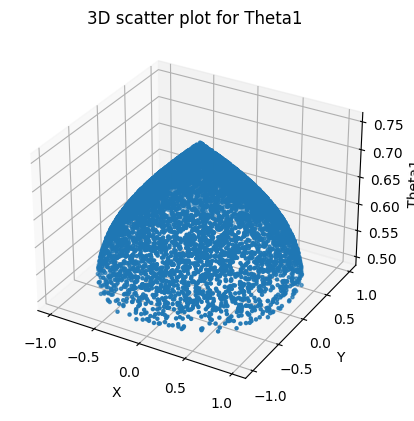

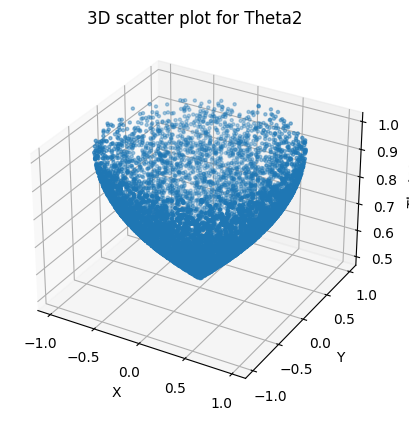

(7073, 2) (7073, 2) (786, 2) (786, 2)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    input_data = []
    target_data = []
    
    for i, line in enumerate(lines):
        # print(i, line)
        if i % 2 == 0:  # Input data (rows 1, 3, 5, 7, ...)
            input_data.append([float(x) for x in line.strip().split()])
        else:          # Target data (rows 2, 4, 6, 8, ...)
            target_data.append([float(x) for x in line.strip().split()])

    # Convert to NumPy arrays and reshape
    input_array = np.array(input_data).reshape(-1, 2)
    target_array = np.array(target_data).reshape(-1, 2)
    
    return input_array, target_array

def inverse_kinematics(L1, L2, target_positions):
    # Initialize arrays to store joint angles
    theta_values = np.zeros((target_positions.shape[0], 2))

    for i, pos in enumerate(target_positions):
        x, y = pos

        # Calculate the distance from the base to the target position
        r = np.sqrt(x**2 + y**2)
        # Check if the target is reachable
        if r > L1 + L2:
            print(f"Target {i} is not reachable.")
            continue

        # Calculate the angle between the first arm segment and the line from the base to the target
        cos_theta1 = (x**2 + y**2 + L1**2 - L2**2) / (2 * L1 * r)
        sin_theta1 = np.sqrt(1 - cos_theta1**2)
        theta1 = np.arctan2(sin_theta1, cos_theta1)

        # Calculate the angle between the first and second arm segments
        cos_theta2 = (L1**2 + L2**2 - x**2 - y**2) / (2 * L1 * L2)
        sin_theta2 = np.sqrt(1 - cos_theta2**2)
        theta2 = np.arctan2(sin_theta2, cos_theta2)

        # Store the joint angles
        theta_values[i, 0] = theta1
        theta_values[i, 1] = theta2

    return theta_values

# Define the lengths of the arm segments
L1 = 0.5
L2 = 0.5
np.random.seed(1)

# Generate 10000 random target positions within a circle of radius 1
target_positions = np.random.rand(10000, 2) * 2 - 1  # This generates points in the range (-1,1)
distances = np.sqrt(target_positions[:,0]**2 + target_positions[:,1]**2)
mask = distances <= 1  # This creates a mask for points within a circle of radius 1
target_positions = target_positions[mask]

# Calculate the joint angles
theta_values = inverse_kinematics(L1, L2, target_positions)
# Normalize the joint angles to the range (0,1)
theta_values = (theta_values + np.pi) / (2 * np.pi)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot for theta1
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(target_positions[:,0], target_positions[:,1], theta_values[:,0], marker='.')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Theta1')
plt.title('3D scatter plot for Theta1')
plt.show()

# Create a 3D scatter plot for theta2
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(target_positions[:,0], target_positions[:,1], theta_values[:,1],marker='.')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Theta2')
plt.title('3D scatter plot for Theta2')
plt.show()


# split to train and test use train_test_split, and convert to tensor
train_in, test_in, train_target, test_target = train_test_split(target_positions, theta_values, test_size=0.1, random_state=6)

# check the shape
print(train_in.shape, train_target.shape, test_in.shape, test_target.shape)

# to tensor
train_in, train_target, test_in, test_target = torch.from_numpy(train_in).float(), torch.from_numpy(train_target).float(), torch.from_numpy(test_in).float(), torch.from_numpy(test_target).float()

# train_in, train_target = read_data('k2jdata/aggregated_train.txt')
# test_in, test_target = read_data('k2jdata/aggregated_test.txt')

# # convert to tensor
# train_in = torch.from_numpy(train_in).float()
# train_target = torch.from_numpy(train_target).float()
# test_in = torch.from_numpy(test_in).float()
# test_target = torch.from_numpy(test_target).float()
# print(train_in.shape, train_target.shape, test_in.shape, test_target.shape)

In [2]:

class dianet(nn.Module):
    def __init__(self):
        super(dianet, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 4)
        self.fc3 = nn.Linear(4, 3)
        self.fc4 = nn.Linear(3, 2)

    def make_mask(self, in_dim, out_dim):
        assert in_dim + 1 == out_dim
        mask = torch.zeros(out_dim, in_dim)
        for i in range(in_dim):
            mask[i, i] = 1
            mask[i + 1, i] = 1
        return mask
    
    def forward(self, x, dwn, up):
        self.fc1.weight.data *= self.make_mask(2, 3)
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data, min=dwn, max=up)
        self.fc1.bias.data = torch.clamp(self.fc1.bias.data, min=dwn, max=up)
        x1 = torch.tanh(self.fc1(x)) # 3

        self.fc2.weight.data *= self.make_mask(3, 4)
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data, min=dwn, max=up)
        self.fc2.bias.data = torch.clamp(self.fc2.bias.data, min=dwn, max=up)
        x2 = torch.tanh(self.fc2(x1)) # 4
        x2_ = torch.cat((x2[:,0:1], x2[:,1:-1]+x, x2[:,-1:]), dim=1)

        self.fc3.weight.data *= self.make_mask(3, 4).T
        self.fc3.weight.data = torch.clamp(self.fc3.weight.data, min=dwn, max=up)
        self.fc3.bias.data = torch.clamp(self.fc3.bias.data, min=dwn, max=up)
        x3 = torch.tanh(self.fc3(x2_)) # 3
        x3_ = x3 + x1

        self.fc4.weight.data *= self.make_mask(2, 3).T
        self.fc4.weight.data = torch.clamp(self.fc4.weight.data, min=dwn, max=up)
        self.fc4.bias.data = torch.clamp(self.fc4.bias.data, min=dwn, max=up)
        x4 = self.fc4(x3_) # 2
        x4_ = x4 + x2[:,1:-1]
        
        return x4_



# clamp -1,1

In [28]:
model = dianet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

minloss = 100
for epoch in range(200):
    batchsize = 8
    epoch_loss = 0
    count = 0
    for i in range(0, train_in.shape[0], batchsize):
        x = train_in[i:i+batchsize]
        y = train_target[i:i+batchsize]
        optimizer.zero_grad()
        outputs = model(x,-1,1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    epoch_loss /= count

    # test the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_in,-1,1)
        test_loss = criterion(test_outputs, test_target)
        # print('epoch: ',epoch, ' loss: ',epoch_loss, ' test loss: ',test_loss.item())
        if test_loss < minloss:
            minloss = test_loss
            torch.save(model.state_dict(), 'k2jdata/dianet-11.pth')
            print('saved at epoch: ',epoch, ' test loss: ',test_loss.item())

saved at epoch:  0  test loss:  0.0074920570477843285
saved at epoch:  1  test loss:  0.007402703631669283
saved at epoch:  2  test loss:  0.007350748870521784
saved at epoch:  3  test loss:  0.007292517926543951
saved at epoch:  4  test loss:  0.007157838903367519
saved at epoch:  5  test loss:  0.00696362042799592
saved at epoch:  6  test loss:  0.006669134832918644
saved at epoch:  7  test loss:  0.005947810597717762
saved at epoch:  8  test loss:  0.0052893515676259995
saved at epoch:  9  test loss:  0.00508100213482976
saved at epoch:  10  test loss:  0.005029417108744383
saved at epoch:  11  test loss:  0.0050211213529109955
saved at epoch:  12  test loss:  0.005013354122638702
saved at epoch:  13  test loss:  0.005011617671698332
saved at epoch:  31  test loss:  0.005011493340134621
saved at epoch:  32  test loss:  0.005011227913200855
saved at epoch:  33  test loss:  0.005010993219912052
saved at epoch:  34  test loss:  0.005010783672332764
saved at epoch:  35  test loss:  0.00

KeyboardInterrupt: 

In [29]:
def relative_error(true_array, approx_array):
    assert true_array.shape == approx_array.shape, "Arrays must have the same shape"
    # Avoid division by zero
    assert not np.all(true_array == 0), "True array should not be all zeros"

    true_array = true_array.reshape(-1)
    approx_array = approx_array.reshape(-1)

    absolute_error_array = np.abs(true_array - approx_array)
    print(true_array, '\n', approx_array)
    relative_error_array = absolute_error_array / np.abs(true_array)

    mean_relative_error = np.mean(relative_error_array)
    return mean_relative_error


model = dianet()
model.load_state_dict(torch.load('k2jdata/dianet-11.pth'))
model.eval()
outputs = model(test_in, -1, 1)
loss = criterion(outputs, test_target)
print('test loss: ', loss.item())
mean_relative_error = relative_error(test_target.numpy(), outputs.detach().numpy())
print('mean relative error: ', mean_relative_error)

test loss:  0.0011575213866308331
[0.5660802  0.8678395  0.57191855 ... 0.7118523  0.62818277 0.74363446] 
 [0.65479755 0.85107934 0.61770755 ... 0.7056082  0.6530105  0.73571205]
mean relative error:  0.037271224


# Clamp 0,1

In [9]:
model = dianet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

minloss = 100
for epoch in range(2000):
    batchsize = 16
    epoch_loss = 0
    count = 0
    for i in range(0, train_in.shape[0], batchsize):
        x = train_in[i:i+batchsize]
        y = train_target[i:i+batchsize]
        optimizer.zero_grad()
        outputs = model(x,0,1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    epoch_loss /= count

    # test the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_in,0,1)
        test_loss = criterion(test_outputs, test_target)
        # print('epoch: ',epoch, ' loss: ',epoch_loss, ' test loss: ',test_loss.item())
        if test_loss < minloss:
            minloss = test_loss
            torch.save(model.state_dict(), 'k2jdata/dianet01.pth')
            print('saved at epoch: ',epoch, ' test loss: ',test_loss.item())

saved at epoch:  0  test loss:  0.14145144820213318
saved at epoch:  1  test loss:  0.13889209926128387
saved at epoch:  2  test loss:  0.13643525540828705
saved at epoch:  3  test loss:  0.13408419489860535
saved at epoch:  4  test loss:  0.13183924555778503
saved at epoch:  5  test loss:  0.12969891726970673
saved at epoch:  6  test loss:  0.1276606023311615
saved at epoch:  7  test loss:  0.12572085857391357
saved at epoch:  8  test loss:  0.12387583404779434
saved at epoch:  9  test loss:  0.12212137132883072
saved at epoch:  10  test loss:  0.12045339494943619
saved at epoch:  11  test loss:  0.11886775493621826
saved at epoch:  12  test loss:  0.1173604354262352
saved at epoch:  13  test loss:  0.11592757701873779
saved at epoch:  14  test loss:  0.11457151174545288
saved at epoch:  15  test loss:  0.11328961700201035
saved at epoch:  16  test loss:  0.11206768453121185
saved at epoch:  17  test loss:  0.11090288311243057
saved at epoch:  18  test loss:  0.10979344695806503
saved

In [11]:
def relative_error(true_array, approx_array):
    assert true_array.shape == approx_array.shape, "Arrays must have the same shape"
    # Avoid division by zero
    assert not np.all(true_array == 0), "True array should not be all zeros"

    true_array = true_array.reshape(-1)
    approx_array = approx_array.reshape(-1)

    absolute_error_array = np.abs(true_array - approx_array)
    print(true_array, '\n', approx_array)
    relative_error_array = absolute_error_array / np.abs(true_array)

    mean_relative_error = np.mean(relative_error_array)
    return mean_relative_error


model = dianet()
model.load_state_dict(torch.load('k2jdata/dianet01.pth'))
model.eval()
outputs = model(test_in, 0, 1)
loss = criterion(outputs, test_target)
print('test loss: ', loss.item())
mean_relative_error = relative_error(test_target.numpy(), outputs.detach().numpy())
print('mean relative error: ', mean_relative_error)

test loss:  0.07898004353046417
[0.15955268 0.8944908  0.15028639 0.43709046 0.29734412 0.7043512
 0.14456518 0.41986057 0.4427256  0.88495517] 
 [0.5264395 0.5311815 0.5264395 0.5311815 0.5264395 0.5311815 0.5264395
 0.5311815 0.5264395 0.5311815]
mean relative error:  0.9935667


# no clmap

In [3]:
model = dianet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

minloss = 100
for epoch in range(2000):
    batchsize = 8
    epoch_loss = 0
    count = 0
    for i in range(0, train_in.shape[0], batchsize):
        x = train_in[i:i+batchsize]
        y = train_target[i:i+batchsize]
        optimizer.zero_grad()
        outputs = model(x,-100,100)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    epoch_loss /= count

    # test the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_in,-100,100)
        test_loss = criterion(test_outputs, test_target)
        # print('epoch: ',epoch, ' loss: ',epoch_loss, ' test loss: ',test_loss.item())
        if test_loss < minloss:
            minloss = test_loss
            torch.save(model.state_dict(), 'k2jdata/dianet_no.pth')
            print('saved at epoch: ',epoch, ' test loss: ',test_loss.item())

saved at epoch:  0  test loss:  0.008908964693546295
saved at epoch:  1  test loss:  0.008035356178879738
saved at epoch:  2  test loss:  0.007889787666499615
saved at epoch:  3  test loss:  0.007798698730766773
saved at epoch:  4  test loss:  0.007627582643181086
saved at epoch:  5  test loss:  0.00736714992672205
saved at epoch:  6  test loss:  0.007284846622496843
saved at epoch:  7  test loss:  0.007276616990566254
saved at epoch:  8  test loss:  0.007275127340108156
saved at epoch:  9  test loss:  0.007274830248206854
saved at epoch:  116  test loss:  0.0072679962031543255
saved at epoch:  117  test loss:  0.007222592830657959
saved at epoch:  118  test loss:  0.006822418887168169
saved at epoch:  119  test loss:  0.00554531579837203
saved at epoch:  120  test loss:  0.0052911993116140366
saved at epoch:  121  test loss:  0.005260843317955732
saved at epoch:  122  test loss:  0.005244807805866003
saved at epoch:  123  test loss:  0.005232216790318489
saved at epoch:  124  test los

In [4]:
def relative_error(true_array, approx_array):
    assert true_array.shape == approx_array.shape, "Arrays must have the same shape"
    # Avoid division by zero
    assert not np.all(true_array == 0), "True array should not be all zeros"

    true_array = true_array.reshape(-1)
    approx_array = approx_array.reshape(-1)

    absolute_error_array = np.abs(true_array - approx_array)
    print(true_array, '\n', approx_array)
    relative_error_array = absolute_error_array / np.abs(true_array)

    mean_relative_error = np.mean(relative_error_array)
    return mean_relative_error


model = dianet()
model.load_state_dict(torch.load('k2jdata/dianet_no.pth'))
model.eval()
outputs = model(test_in, -100, 100)
loss = criterion(outputs, test_target)
print('test loss: ', loss.item())
mean_relative_error = relative_error(test_target.numpy(), outputs.detach().numpy())
print('mean relative error: ', mean_relative_error)

test loss:  9.853005758486688e-05
[0.62980556 0.7403889  0.7196706  ... 0.6881637  0.68067735 0.6386453 ] 
 [0.6337173  0.73650545 0.7166208  ... 0.67435324 0.6792658  0.6284939 ]
mean relative error:  0.010654141
